In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geodatasets
import os
import ast
import math

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [49]:
df = pd.read_csv(os.path.join('..', 'data', 'NEI_pollution_source_2020.csv'), dtype={'FIPS':str, 'Emissions (Tons)':float}, thousands=',')

df['Lat/Lon'] = df['Lat/Lon'].apply(ast.literal_eval)

# separate lat lon corrdinates
df['Lon'] = df["Lat/Lon"].apply(lambda x: x[0])
df['Lat'] = df["Lat/Lon"].apply(lambda x: x[1])

df.head()

/var/folders/0b/l4__m5492hg2pxtxg6z149mh0000gn/T/ipykernel_62871/3250663768.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join('..', 'data', 'NEI_pollution_source_2020.csv'), dtype={'FIPS':str, 'Emissions (Tons)':float}, thousands=',')


,State,State-County,Pollutant,Emissions (Tons),Pollutant Type,Site Name,EIS Facility ID,Facility Type,Street Address,NAICS,Lat/Lon,EPA Region,FIPS,Lon,Lat
0,Alabama,AL - Autauga,Carbon Dioxide,2.391966e+06,GHG,Alabama Power Company,10708711,Electricity Generation via Combustion,3305 County Road 26,Fossil Fuel Electric Power Generation,"[-86.738287, 32.650024]",4,01001,-86.738287,32.650024
1,Alabama,AL - Autauga,Nitrogen Oxides,2.110000e+02,CAP,Alabama Power Company,10708711,Electricity Generation via Combustion,3305 County Road 26,Fossil Fuel Electric Power Generation,"[-86.738287, 32.650024]",4,01001,-86.738287,32.650024
2,Alabama,AL - Autauga,Ammonia,1.097200e+02,CAP,Alabama Power Company,10708711,Electricity Generation via Combustion,3305 County Road 26,Fossil Fuel Electric Power Generation,"[-86.738287, 32.650024]",4,01001,-86.738287,32.650024
3,Alabama,AL - Autauga,PM2.5 Primary (Filt + Cond),9.240000e+01,CAP,Alabama Power Company,10708711,Electricity Generation via Combustion,3305 County Road 26,Fossil Fuel Electric Power Generation,"[-86.738287, 32.650024]",4,01001,-86.738287,32.650024
4,Alabama,AL - Autauga,PM10 Primary (Filt + Cond),9.240000e+01,CAP,Alabama Power Company,10708711,Electricity Generation via Combustion,3305 County Road 26,Fossil Fuel Electric Power Generation,"[-86.738287, 32.650024]",4,01001,-86.738287,32.650024


### Split files into smaller files
In order to host on github, you can split the large csv files into somaller ones with this code cell.

In [35]:
split_files = input('Do you want to split files? (Y/n)')

if split_files.upper() == 'Y':
    file_size = os.path.getsize(os.path.join('data', 'NEI_pollution_source_2020.csv')) / 1e6
    # github filesize limit is 50 Mb. Need to split this file into several files to upload them
    n_files = math.ceil(file_size / 50)
    n_rows = df.shape[0]
    row_limit = n_rows // n_files

    splits = range(0, n_rows + 1, row_limit)

    save_data_dir = os.path.join('data', 'nei_pollution')

    if not os.path.exists(save_data_dir):
        os.makedirs(save_data_dir)

    for i, start_end in enumerate(zip(splits[:-1], splits[1:])):
        start = start_end[0]
        end = start_end[1]

        file_name = f'NEI_point_source_pollution_{i}.csv'
        df.iloc[start:end, :].to_csv(os.path.join(save_data_dir, file_name))

    print('All done!')


### Just Focus on a Single State
DBSCAN is computationally expensive, and there's 1M rows in this dataset. Just filter to state level so DBSCAN has an easier time to rune

In [50]:
locations_df = df[['EIS Facility ID', 'Site Name', 'State', 'Lat', 'Lon']]
locations_df = locations_df.drop_duplicates()
locations_df.head()

# just keep california because trying to cluster eveything seems to crash jupyter
ca_df = locations_df.loc[locations_df['State'] == 'California', :]
ca_df.head()

,EIS Facility ID,Site Name,State,Lat,Lon
39167,18172311,7-11 STORE,California,37.702889,-121.721006
39173,18175311,7-11 STORE #33163,California,37.718678,-121.910240
39179,18366311,7-ELEVEN,California,37.717347,-121.723735
39185,18172511,7-ELEVEN #32734,California,37.698070,-121.772987
39191,18521411,7-ELEVEN INC.,California,37.795672,-122.253424


### Find a good value for epsilon
Tuning epsilon is the most important parameter for dbscan. Too small, and there will be too many adjacent clusterss; too alrge, and everything will be lumped into one big cluster. Find limit where space between points starts rapidly increasing. Seems to happen around 0.03.

(0.0, 0.1)

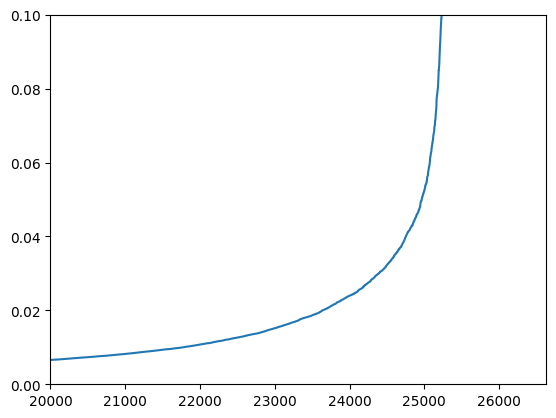

In [51]:
# find nearest neghbbors to tune dbscan
nn = NearestNeighbors(n_neighbors=25)
nn_fit = nn.fit(ca_df[['Lat', 'Lon']])
dist, indices = nn_fit.kneighbors(ca_df[['Lat', 'Lon']])

dist = np.sort(dist, axis=0)
dist = dist[:, 1]
plt.plot(dist)
plt.xlim(20000)
plt.ylim(0, 0.1)

In [52]:
dbscan = DBSCAN(eps=0.03)
ca_df['Cluster'] = dbscan.fit_predict(ca_df[['Lat', 'Lon']])
ca_df['Cluster'] = ca_df['Cluster'].astype(str)
ca_df.head()

/var/folders/0b/l4__m5492hg2pxtxg6z149mh0000gn/T/ipykernel_62871/2350223037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca_df['Cluster'] = dbscan.fit_predict(ca_df[['Lat', 'Lon']])
/var/folders/0b/l4__m5492hg2pxtxg6z149mh0000gn/T/ipykernel_62871/2350223037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca_df['Cluster'] = ca_df['Cluster'].astype(str)


,EIS Facility ID,Site Name,State,Lat,Lon,Cluster
39167,18172311,7-11 STORE,California,37.702889,-121.721006,0
39173,18175311,7-11 STORE #33163,California,37.718678,-121.910240,0
39179,18366311,7-ELEVEN,California,37.717347,-121.723735,0
39185,18172511,7-ELEVEN #32734,California,37.698070,-121.772987,0
39191,18521411,7-ELEVEN INC.,California,37.795672,-122.253424,1


In [53]:
ca_df.groupby('Cluster').count()

,EIS Facility ID,Site Name,State,Lat,Lon
Cluster,,,,,
-1,2457,2457,2457,2457,2457
0,418,418,418,418,418
1,7595,7595,7595,7595,7595
10,6,6,6,6,6
100,9,9,9,9,9
...,...,...,...,...,...
95,5,5,5,5,5
96,9,9,9,9,9
97,14,14,14,14,14


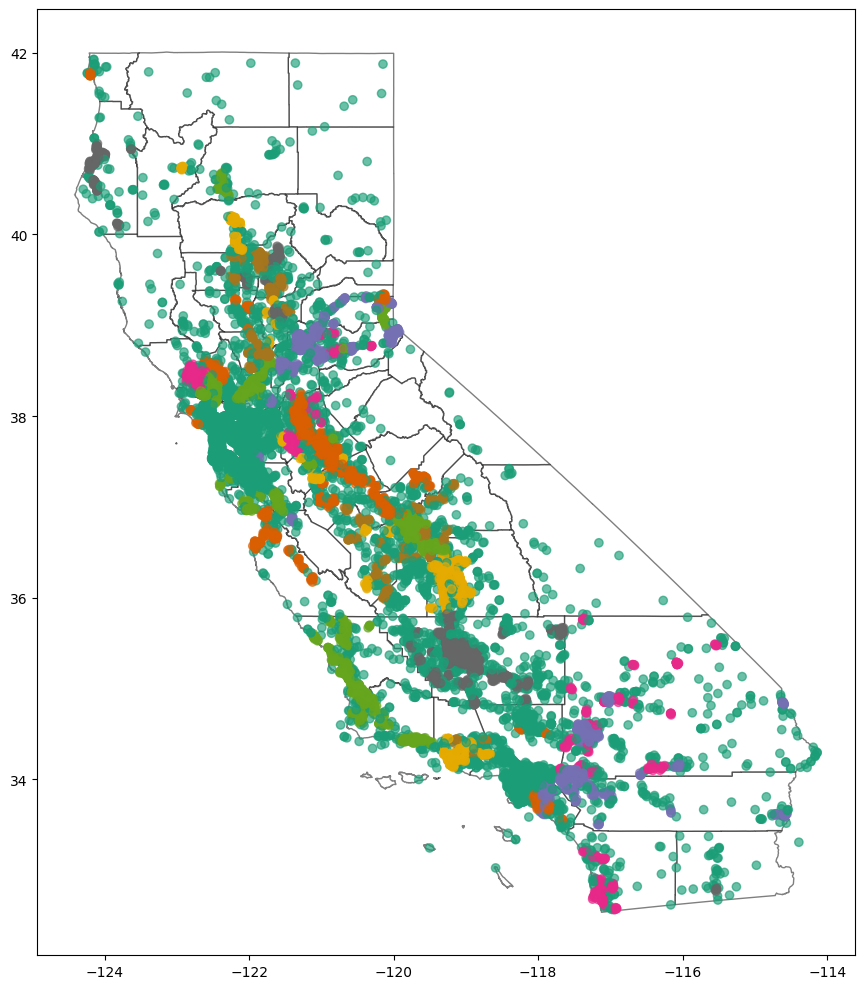

In [54]:
gdf = gpd.GeoDataFrame(ca_df, geometry = gpd.points_from_xy(ca_df.Lon, ca_df.Lat), crs="EPSG:4326")

ca_county_lines = 'California_Counties.geojson'

california = gpd.read_file(os.path.join('..', 'data', ca_county_lines))
ax = california.plot(figsize=(10,10), alpha=0.5, edgecolor='k', color='white')

legend = False
gdf.plot(kind='geo', column='Cluster', legend=legend, alpha = 0.65, ax=ax, cmap='Dark2')

if legend:
    leg = ax.get_legend()
    leg.set_bbox_to_anchor((1, 0.5, 0.1, 0.1))

plt.tight_layout()

In [55]:
site_sums_df = df[['EIS Facility ID', 'Emissions (Tons)']].groupby('EIS Facility ID', as_index=False).sum()
site_sums_df = locations_df.merge(site_sums_df, on='EIS Facility ID')
ca_sums_df = site_sums_df.merge(ca_df[['EIS Facility ID', 'Cluster']], on='EIS Facility ID')
ca_sums_df.describe()

,EIS Facility ID,Lat,Lon,Emissions (Tons)
count,2.536600e+04,25366.000000,25366.000000,2.536600e+04
mean,1.304782e+07,36.998224,-120.753437,3.543271e+03
std,6.413190e+06,1.622029,1.693073,8.161310e+04
min,1.110000e+02,32.562466,-124.294220,0.000000e+00
25%,1.005119e+07,35.771619,-122.073135,1.717000e-02
50%,1.437416e+07,37.464456,-121.283075,1.219800e-01
75%,1.841509e+07,37.952801,-119.560837,6.722600e-01
max,2.148311e+07,41.927260,-114.139670,6.198461e+06


<Axes: xlabel='Emissions (Tons)', ylabel='Percent'>

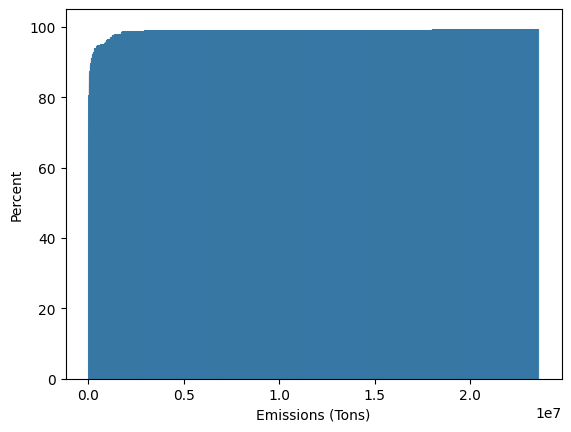

In [56]:
ca_cluster_df = ca_sums_df.loc[:, 'Emissions (Tons)':].groupby('Cluster').sum()
total_emissions = ca_cluster_df['Emissions (Tons)'].sum()
ca_cluster_df['Percent of Total Emissions'] = ca_cluster_df['Emissions (Tons)'] / total_emissions
ca_cluster_df['Emissions (kTons)'] = ca_cluster_df['Emissions (Tons)'] / 1000
cum_percent_total_emissions = np.cumsum(ca_cluster_df['Percent of Total Emissions'].sort_values())
# sns.lineplot(y = cum_percent_total_emissions, x = cum_percent_total_emissions.index)
sns.histplot(ca_cluster_df, x='Emissions (Tons)', cumulative=True, stat='percent')

In [118]:
ca_cluster_df

,Emissions (Tons),Percent of Total Emissions,Emissions (kTons)
Cluster,,,
-1,1.800265e+07,2.002996e-01,18002.646843
0,2.042408e+04,2.272408e-04,20.424082
1,2.361008e+07,2.626886e-01,23610.081649
10,4.734799e+00,5.267993e-08,0.004735
100,2.790769e+00,3.105042e-08,0.002791
...,...,...,...
95,9.789080e+00,1.089145e-07,0.009789
96,7.702174e+03,8.569530e-05,7.702174
97,7.138932e+00,7.942860e-08,0.007139


In [57]:
ca_cluster_df.quantile([0.75, 0.8, 0.9, 0.95, 0.99])

,Emissions (Tons),Percent of Total Emissions,Emissions (kTons)
0.75,7.123475e+03,0.000079,7.123475
0.80,1.557023e+04,0.000173,15.570232
0.90,1.240378e+05,0.001380,124.037816
0.95,5.207049e+05,0.005793,520.704870
0.99,2.553903e+06,0.028415,2553.903487


In [58]:
ca_cluster_df.loc[ca_cluster_df['Emissions (Tons)'] > 521, :].sum()

Emissions (Tons)              8.987117e+07
Percent of Total Emissions    9.999173e-01
Emissions (kTons)             8.987117e+04
dtype: float64

In [59]:
ca_cluster_df.loc['225', :]

Emissions (Tons)              1.736196e+06
Percent of Total Emissions    1.931713e-02
Emissions (kTons)             1.736196e+03
Name: 225, dtype: float64

In [60]:
# top 10 emissions
top_clusters = ca_cluster_df.sort_values('Percent of Total Emissions', ascending=False).iloc[:10, :].index
top_clusters

Index(['122', '1', '-1', '197', '81', '225', '155', '224', '107', '89'], dtype='object', name='Cluster')

In [61]:
total_emissions

np.float64(89878601.13703999)

In [71]:
site_sums_df.head()

,EIS Facility ID,Site Name,State,Lat,Lon,Emissions (Tons)
0,10708711,Alabama Power Company,Alabama,32.650024,-86.738287,2.392574e+06
1,10583011,Autauga County,Alabama,32.438780,-86.510450,3.021771e+03
2,7212311,International Paper Company,Alabama,32.418731,-86.471209,2.006220e+06
3,10583111,Southern Power Company,Alabama,32.381158,-86.573937,1.828790e+06
4,560011,Tenaska Alabama Partners LP,Alabama,32.653072,-86.738872,8.614507e+05


In [69]:
top_clusters_df

,EIS Facility ID,Site Name,State,Lat,Lon,Cluster
39191,18521411,7-ELEVEN INC.,California,37.795672,-122.253424,1
39197,18172911,7-ELEVEN STORE #18916,California,37.570452,-122.032385,1
39203,18525211,7-ELEVEN STORE #35341,California,37.665608,-122.113580,1
39209,19278411,7TH STREET PROPERTIES,California,37.852502,-122.292230,1
39230,19278511,7TH STREET PROPERTIES II,California,37.852384,-122.293652,1
...,...,...,...,...,...,...
278899,20979211,SUPER POWER MART II,California,39.328025,-121.342485,-1
278921,3698011,US PIPE AND FABRICATION,California,39.030445,-121.522277,-1
278929,15708611,"VISHAAN, INC",California,39.228710,-121.413220,-1
278950,15914511,WHEATLAND CHEVRON,California,39.014210,-121.431660,-1


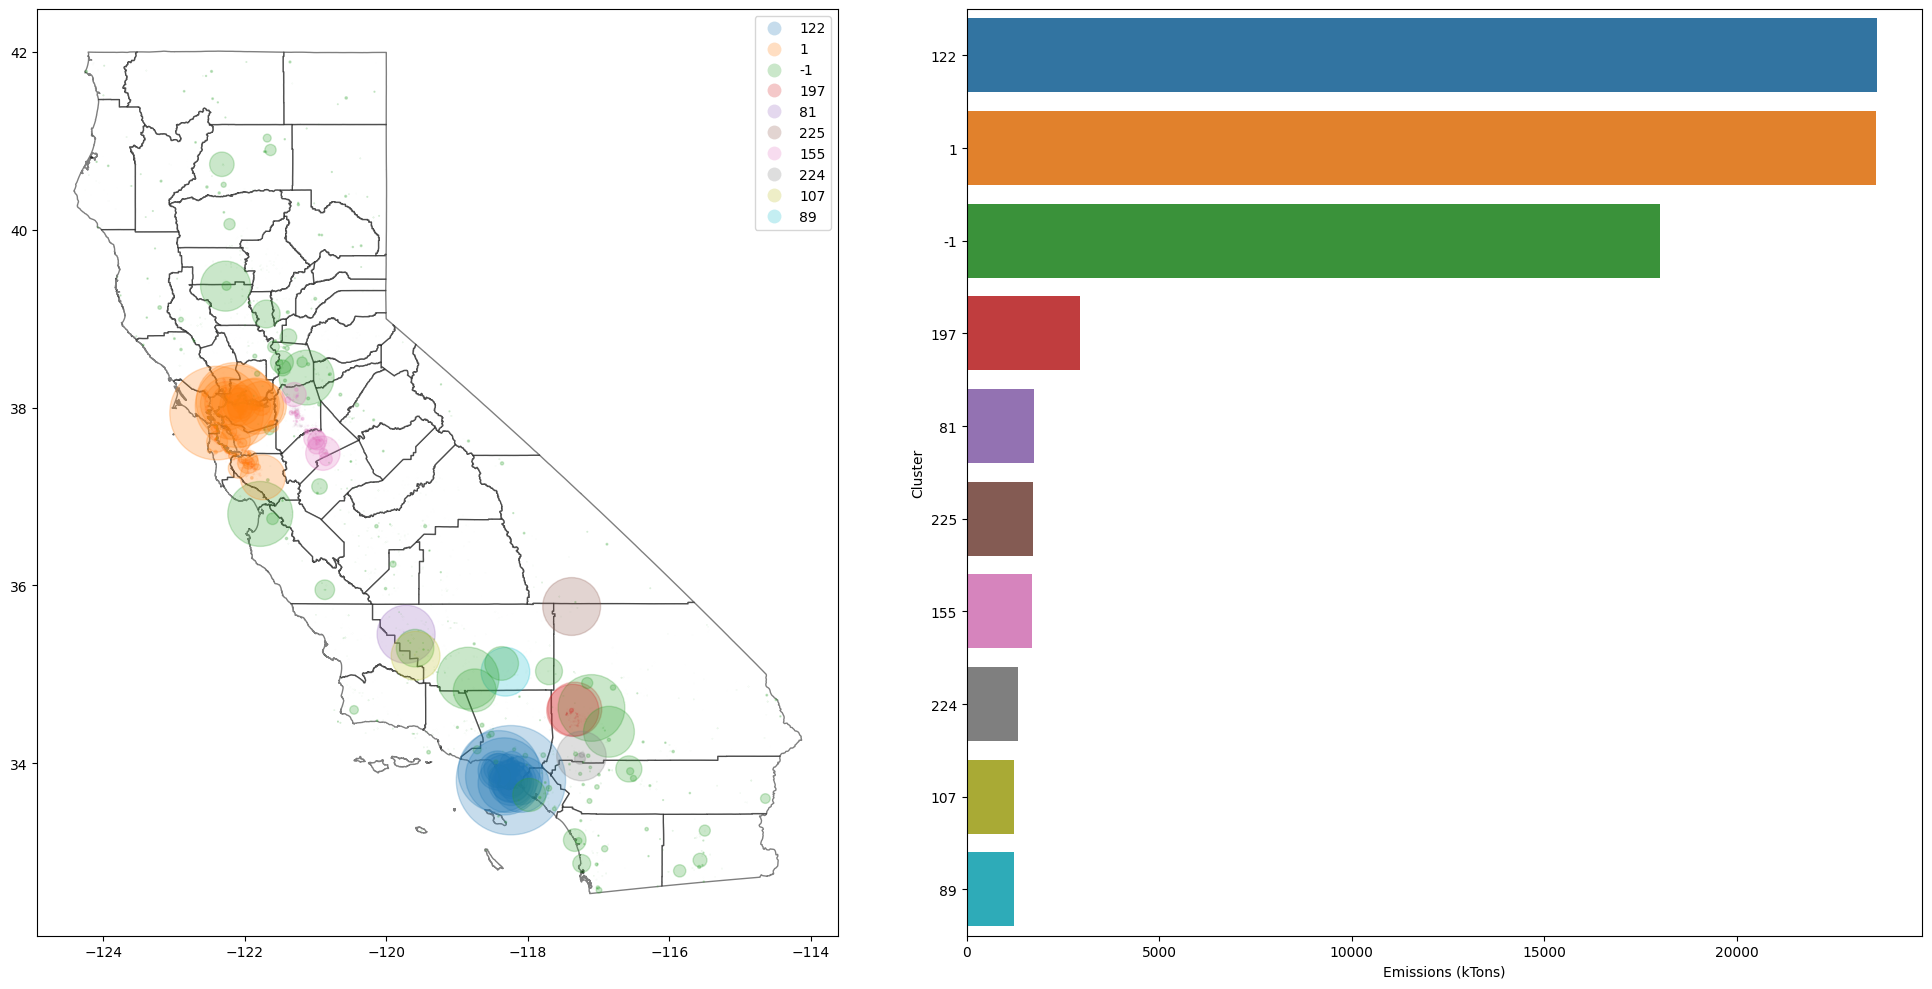

In [79]:
top_clusters_df = ca_df.loc[ca_df.Cluster.isin(top_clusters), :]

cluster_emissions_df = top_clusters_df.merge(site_sums_df[['EIS Facility ID', 'Emissions (Tons)']], on='EIS Facility ID')
cluster_emissions_df = cluster_emissions_df.drop_duplicates(subset = 'EIS Facility ID')
cluster_emissions_df['Emissions (kTons)'] = cluster_emissions_df['Emissions (Tons)'] / 1000

gdf = gpd.GeoDataFrame(cluster_emissions_df, geometry = gpd.points_from_xy(cluster_emissions_df.Lon, cluster_emissions_df.Lat), crs="EPSG:4326")

ca_county_lines = 'California_Counties.geojson'

california = gpd.read_file(os.path.join('..', 'data', ca_county_lines))

fig, axes = plt.subplots(1, 2, figsize=(20,10))

ax_map = axes[0]

california.plot(alpha=0.5, edgecolor='k', color='white', ax = ax_map)

legend = True
gdf.plot(kind='geo', column='Cluster', legend=legend, alpha = 0.25, ax=ax_map, cmap='tab10', 
         markersize='Emissions (kTons)',
         categories=top_clusters)

# bar chart next to map
ax_bar = axes[1]

bar_plot_df = cluster_emissions_df.groupby('Cluster', as_index=False).sum().reset_index()
bar_plot_df = bar_plot_df.sort_values('Emissions (kTons)', ascending=False)
sns.barplot(bar_plot_df, x='Emissions (kTons)', y='Cluster', hue='Cluster', ax=ax_bar, palette='tab10')
# ax_bar.vlines(total_emissions / 1000, ymin=top_clusters[0], ymax=top_clusters[-1])

plt.tight_layout()